# Assignment: Video Quality Inference

To this point in the class, you have learned various techniques for leading and analyzing packet captures of various types, generating features from those packet captures, and training and evaluating models using those features.

In this assignment, you will put all of this together, using a network traffic trace to train a model to automatically infer video quality of experience from a labeled traffic trace.

## Part 1: Warmup

The first part of this assignment builds directly on the hands-on activities but extends them slightly.

### Extract Features from the Network Traffic

Load the `netflix.pcap` file, which is a packet trace that includes network traffic. 

Click [here](https://github.com/noise-lab/ml-systems/blob/main/docs/notebooks/data/netflix.pcap) to download `netflix.pcap`.


In [1]:
from scapy.all import rdpcap

packets = rdpcap('netflix.pcap')

### Identifying the Service Type

Use the DNS traffic to filter the packet trace for Netflix traffic.

In [2]:
from scapy.all import DNS, DNSQR, DNSRR

NF_DOMAINS = ["nflxvideo", "netflix", "nflxso", "nflxext"]

nf_txids = []
for pkt in packets:
    if pkt.haslayer(DNSQR):
        qname = pkt[DNSQR].qname.decode() if isinstance(pkt[DNSQR].qname, bytes) else str(pkt[DNSQR].qname)
        if any(domain in qname for domain in NF_DOMAINS):
            nf_txids.append(pkt[DNS].id)

nf_ipl = []
for pkt in packets:
    if pkt.haslayer(DNSRR) and pkt[DNS].id in nf_txids:
        for i in range(pkt[DNS].ancount):
            answer = pkt[DNSRR][i]
            if answer.type == 1:  # A record
                nf_ipl.append(answer.rdata)

nf_ipl = list(set(nf_ipl))
print(nf_ipl)

['198.38.120.153', '198.38.120.162', '52.210.133.255', '198.38.120.167', '198.38.120.164', '52.19.39.146', '198.38.120.137', '34.252.77.54', '198.38.120.130', '52.48.148.78', '198.38.120.166', '52.208.128.101', '198.38.120.134', '52.210.19.176', '52.48.8.150', '23.57.80.120']


### Generate Statistics

Generate statistics and features for the Netflix traffic flows. Use the `netml` library or any other technique that you choose to generate a set of features that you think would be good features for your model. 

In [3]:
from netml.pparser.parser import PCAP
import pandas as pd

pcap = PCAP("netflix.pcap")
pcap.pcap2flows()
pcap.flow2features("STATS")
feat_stats = pd.DataFrame(pcap.features)

meta = pd.DataFrame([{
    "src": f[0][0],
    "dst": f[0][1],
    "sport": f[0][2],
    "dport": f[0][3],
    "proto": f[0][4]
} for f in pcap.flows])

print(f"feat_stats shape: {feat_stats.shape}")
print(f"meta shape: {meta.shape}")

features = pd.concat([meta, feat_stats], axis=1)
nf_set = set(nf_ipl)
nf_features = features[features["src"].isin(nf_set) | features["dst"].isin(nf_set)]
nf_features.head()



"""

The STATS feature set captures core flow-level statistics such as number of packets sent per second, number of bytes per second. These metrics summarize the fundamental traffic characteristics that influence streaming quality.

"""


feat_stats shape: (184, 12)
meta shape: (184, 5)


,src,dst,sport,dport,proto,0,1,2,3,4,5,6,7,8,9,10,11
12,192.168.43.72,198.38.120.130,58451,443,6,14.440177,0.831015,73.683308,88.666667,48.140997,66.0,66.0,69.0,66.0,200.0,12.0,1064.0
13,192.168.43.72,198.38.120.130,58452,443,6,14.442865,0.761622,69.099863,90.727273,49.772374,66.0,66.0,72.0,66.0,200.0,11.0,998.0
14,192.168.43.72,198.38.120.130,58453,443,6,14.437420,0.831173,73.697377,88.666667,48.140997,66.0,66.0,69.0,66.0,200.0,12.0,1064.0
15,192.168.43.72,52.19.39.146,58454,443,6,138.854511,1.497971,184.560082,123.206731,66.443951,66.0,66.0,200.0,54.0,200.0,208.0,25627.0
16,192.168.43.72,52.19.39.146,58455,443,6,74.817607,0.360878,45.203263,125.259259,66.350692,66.0,66.0,200.0,54.0,200.0,27.0,3382.0


**Write a brief justification for the features that you have chosen.**

### Inferring Segment downloads

In addition to the features that you could generate using the `netml` library or similar, add to your feature vector a "segment downloads rate" feature, which indicates the number of video segments downloaded for a given time window.

Note: If you are using the `netml` library, generating features with `SAMP` style options may be useful, as this option gives you time windows, and you can then simply add the segment download rate to that existing dataframe.

In [18]:
from scapy.all import IP, TCP, Raw
import numpy as np

pcap.flow2features("SAMP_NUM", fft=False, header=False)
feat_samp = pd.DataFrame(pcap.features)

flows = {}
for p in packets:
    if not (p.haslayer(IP) and p.haslayer(TCP)):
        continue
    ip, tcp = p[IP], p[TCP]
    key = (ip.src, tcp.sport, ip.dst, tcp.dport)
    l = len(bytes(p[Raw])) if p.haslayer(Raw) else 0
    flows.setdefault(key, []).append((float(p.time), l, ip.src, ip.dst))

seg_rate = np.zeros_like(feat_samp.values)
GAP = 1.0

for i, row in features.reset_index(drop=True).iterrows():
    key = (row["src"], int(row["sport"]), row["dst"], int(row["dport"]))
    L = sorted(flows.get(key, []))
    if not L: continue

    times = [t for t, l, _, _ in L if l > 0]
    if len(times) < 2: continue

    seg_times = [times[0]]
    for j in range(1, len(times)):
        if times[j] - times[j - 1] >= GAP:
            seg_times.append(times[j])

    t0, t1 = L[0][0], L[-1][0]
    n = feat_samp.shape[1]
    edges = np.linspace(t0, t1, n + 1)
    sidx = np.digitize(seg_times, edges) - 1
    sidx = sidx[(sidx >= 0) & (sidx < n)]
    seg_rate[i, :] = np.bincount(sidx, minlength=n)

feat_seg = pd.DataFrame(seg_rate)
features = pd.concat([meta, feat_stats, feat_seg], axis=1)

nf_set = set(nf_ipl)
nf_features = features[features["src"].isin(nf_set) | features["dst"].isin(nf_set)]
nf_features.head()


,src,dst,sport,dport,proto,0,1,2,3,4,...,349,350,351,352,353,354,355,356,357,358
12,192.168.43.72,198.38.120.130,58451,443,6,14.440177,0.831015,73.683308,88.666667,48.140997,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,192.168.43.72,198.38.120.130,58452,443,6,14.442865,0.761622,69.099863,90.727273,49.772374,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,192.168.43.72,198.38.120.130,58453,443,6,14.437420,0.831173,73.697377,88.666667,48.140997,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,192.168.43.72,52.19.39.146,58454,443,6,138.854511,1.497971,184.560082,123.206731,66.443951,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,192.168.43.72,52.19.39.146,58455,443,6,74.817607,0.360878,45.203263,125.259259,66.350692,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Part 2: Video Quality Inference

You will now load the complete video dataset from a previous study to train and test models based on these features to automatically infer the quality of a streaming video flow.

For this part of the assignment, you will need two pickle files, which we provide for you by running the code below:

```

!gdown 'https://drive.google.com/uc?id=1N-Cf4dJ3fpak_AWgO05Fopq_XPYLVqdS' -O netflix_session.pkl
!gdown 'https://drive.google.com/uc?id=1PHvEID7My6VZXZveCpQYy3lMo9RvMNTI' -O video_dataset.pkl

```

### Load the File

Load the video dataset pickle file.

In [5]:
import pickle

with open("netflix_session.pkl", "rb") as f:
    data = pickle.load(f)

print(type(data))

C:\Users\tianc\AppData\Local\Temp\ipykernel_40588\444966469.py:4: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  data = pickle.load(f)


<class 'pandas.core.frame.DataFrame'>


### Clean the File

1. The dataset contains video resolutions that are not valid. Remove entries in the dataset that do not contain a valid video resolution. Valid resolutions are 240, 360, 480, 720, 1080.

In [6]:
print(data.columns.tolist())
resolutions = [240, 360, 480, 720, 1080]
data = data[data["resolution"].isin(resolutions)]

['10_EWMA_chunksizes', '10_avg_chunksize', '10_chunksizes_50', '10_chunksizes_50R', '10_chunksizes_75', '10_chunksizes_75R', '10_chunksizes_85', '10_chunksizes_85R', '10_chunksizes_90', '10_chunksizes_90R', '10_max_chunksize', '10_min_chunksize', '10_std_chunksize', 'absolute_timestamp', 'access_50_perc', 'access_75_perc', 'access_avg', 'access_max', 'access_min', 'access_stddev', 'access_var', 'ads', 'all_prev_down_chunk_iat_50', 'all_prev_down_chunk_iat_50R', 'all_prev_down_chunk_iat_75', 'all_prev_down_chunk_iat_75R', 'all_prev_down_chunk_iat_85', 'all_prev_down_chunk_iat_85R', 'all_prev_down_chunk_iat_90', 'all_prev_down_chunk_iat_90R', 'all_prev_down_chunk_iat_avg', 'all_prev_down_chunk_iat_max', 'all_prev_down_chunk_iat_min', 'all_prev_down_chunk_iat_std', 'all_prev_up_chunk_iat_50', 'all_prev_up_chunk_iat_50R', 'all_prev_up_chunk_iat_75', 'all_prev_up_chunk_iat_75R', 'all_prev_up_chunk_iat_85', 'all_prev_up_chunk_iat_85R', 'all_prev_up_chunk_iat_90', 'all_prev_up_chunk_iat_90R',

2. The file also contains columns that are unnecessary (in fact, unhelpful!) for performing predictions. Identify those columns, and remove them.

In [7]:
unhelpful = [
    "session_id", "video_id", "deployment_session_id", "home_id", "service",
    "index", "absolute_timestamp", "relative_timestamp",
    "chunk_start_time", "chunk_end_time", "video_position",
    "cumsum_chunksizes", "cumsum_diff", "size_diff_previous",
    "serverAckFlags", "serverFinFlags", "serverPshFlags", "serverRstFlags",
    "serverSynFlags", "serverUrgFlags", "serverXRetransmit",
    "userAckFlags", "userFinFlags", "userPshFlags", "userRstFlags",
    "userSynFlags", "userUrgFlags", "userXRetransmit",
    "serverZeroRetransmit", "userZeroRetransmit",
    "serverOneRetransmit", "userOneRetransmit",
    "serverTwoRetransmit", "userTwoRetransmit",
    "service_non_video_throughput_down", "service_non_video_throughput_up",
    "startup3.3", "startup5", "startup6.6", "startup10", "startup_mc"
]

data = data.drop(columns=unhelpful)


"""

There are over 200 columns and I couldn't understand the meaning of most of them.
I simply asked ChatGPT to select a list that is most likely irrelevant to predicting streaming
quality.

"""

**Briefly explain why you removed those columns.**

### Prepare Your Data

Prepare your data matrix, determine your features and labels, and perform a train-test split on your data.

In [8]:
from sklearn.model_selection import train_test_split

X = data.drop(columns=["resolution"])
y = data["resolution"]

print("Data type:", data["resolution"].dtype)
unique_vals = data["resolution"].unique()
print("\nUnique values:", unique_vals[:20])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, shuffle=True)

Data type: float64

Unique values: [ 360.  480.  720. 1080.  240.]


### Train and Tune Your Model

1. Select a model of your choice.
2. Train the model using your training data.

In [9]:
import numpy as np
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import classification_report

num_cols = X_train.select_dtypes(include=[np.number]).columns
X_train_dataset = X_train[num_cols].replace([np.inf, -np.inf], np.nan).fillna(0.0).to_numpy()
X_test_dataset = X_test[num_cols].replace([np.inf, -np.inf], np.nan).fillna(0.0).to_numpy()

ridge = RidgeClassifier(alpha=1)
ridge.fit(X_train_dataset, y_train)

y_pred = ridge.predict(X_test_dataset)

print(classification_report(y_test, y_pred, digits=3))


              precision    recall  f1-score   support

       240.0      0.706     0.279     0.400        86
       360.0      0.708     0.491     0.580       222
       480.0      0.743     0.951     0.834      1480
       720.0      0.720     0.244     0.365       483
      1080.0      0.868     0.968     0.915       217

    accuracy                          0.751      2488
   macro avg      0.749     0.587     0.619      2488
weighted avg      0.745     0.751     0.712      2488



### Tune Your Model

Perform hyperparameter tuning to find optimal parameters for your model.

In [10]:
import numpy as np
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score

num_cols = X_train.select_dtypes(include=[np.number]).columns
X_train_dataset = X_train[num_cols].replace([np.inf, -np.inf], np.nan).fillna(0.0).to_numpy()
X_test_dataset = X_test[num_cols].replace([np.inf, -np.inf], np.nan).fillna(0.0).to_numpy()

ridge = RidgeClassifier()
candidates = {"alpha": [0.01, 0.1, 1, 10, 100, 1000]}
search = GridSearchCV(ridge, candidates, cv=5, scoring="accuracy")
search.fit(X_train_dataset, y_train)

best = search.best_estimator_
y_pred = best.predict(X_test_dataset)

acc = accuracy_score(y_test, y_pred)

f1_macro = f1_score(y_test, y_pred, average="macro")
f1_weighted = f1_score(y_test, y_pred, average="weighted")

labels = list(best.classes_)
cm = confusion_matrix(y_test, y_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=[f"true_{c}" for c in labels], columns=[f"pred_{c}" for c in labels])

scores = best.decision_function(X_test_dataset)

scores_max = np.max(scores, axis=1, keepdims=True)
exp_scores = np.exp(scores - scores_max)
proba = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

auc_ovr = roc_auc_score(y_test, proba, multi_class="ovr")
auc_ovo = roc_auc_score(y_test, proba, multi_class="ovo")

print(f"Accuracy:{acc}")
print(f"F1 (macro):{f1_macro}")
print(f"F1 (weighted):{f1_weighted}")
print("Confusion Matrix:")
print(cm_df)
print(f"ROC-AUC (OVR):{auc_ovr}")
print(f"ROC-AUC (OVO):{auc_ovo}")

C:\Users\tianc\PycharmProjects\video-quality-of-experience-ArchLuke\.venv1\Lib\site-packages\scipy\_lib\_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=6.54611e-28): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
C:\Users\tianc\PycharmProjects\video-quality-of-experience-ArchLuke\.venv1\Lib\site-packages\scipy\_lib\_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.58041e-27): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
C:\Users\tianc\PycharmProjects\video-quality-of-experience-ArchLuke\.venv1\Lib\site-packages\scipy\_lib\_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=6.85015e-28): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
C:\Users\tianc\PycharmProjects\video-quality-of-experience-ArchLuke\.venv1\Lib\site-packages\scipy\_lib\_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.76027e-27): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
C:\U

Accuracy:0.7508038585209004
F1 (macro):0.6187210485626581
F1 (weighted):0.7123034537620655
Confusion Matrix:
             pred_240.0  pred_360.0  pred_480.0  pred_720.0  pred_1080.0
true_240.0           24           9          49           4            0
true_360.0            5         109         101           7            0
true_480.0            3          35        1407          29            6
true_720.0            2           1         336         118           26
true_1080.0           0           0           1           6          210
ROC-AUC (OVR):0.9011089979198751
ROC-AUC (OVO):0.9007784087100905


### Evaluate Your Model

Evaluate your model accuracy according to the following metrics:

1. Accuracy
2. F1 Score
3. Confusion Matrix
4. ROC/AUC

## Part 3: Predict the Ongoing Resolution of a Real Netflix Session

Now that you have your model, it's time to put it in practice!

Use a preprocessed Netflix video session to infer **and plot** the resolution at 10-second time intervals.

C:\Users\tianc\AppData\Local\Temp\ipykernel_40588\674869344.py:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  raw = pickle.load(f)


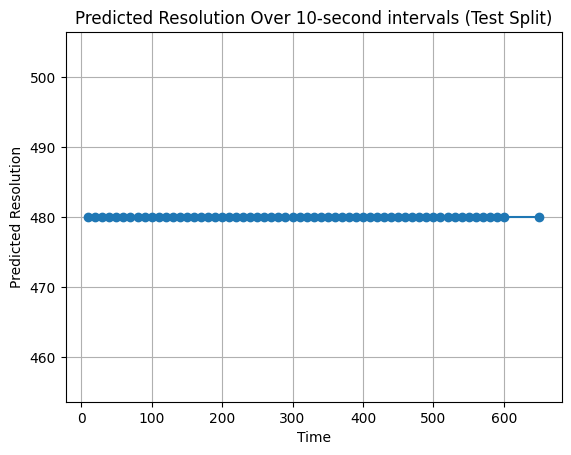

In [17]:
import matplotlib.pyplot as plt
import pickle
import numpy as np

with open("netflix_session.pkl","rb") as f:
    raw = pickle.load(f)

data = raw[raw["resolution"].isin([240,360,480,720,1080])]
data = data.drop(columns=[c for c in unhelpful if c!="relative_timestamp"])
data["time_bin"] = (data["relative_timestamp"]//10).astype(int)

test = data.loc[X_test.index].copy()

agg = test.groupby("time_bin",as_index=False)[num_cols].mean()
X = agg[num_cols].to_numpy()
pred = best.predict(X)

plt.plot(agg["time_bin"]*10,pred,marker="o")
plt.xlabel("Time"); plt.ylabel("Predicted Resolution")
plt.title("Predicted Resolution Over 10-second intervals (Test Split)")
plt.grid(True)
plt.show()
